# Cross-validation of GefCOM2014

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import deep4cast.models as models
import deep4cast.cv as cv

from deep4cast.forecasters import Forecaster

%matplotlib inline

# Parameters

In [15]:
lag = 48
horizon = 24
filters=32
num_layers=2
lr=0.001
epochs=10
test_fraction = 0.1
n_folds=1

# Load the data from file
df = pd.read_pickle('../data/processed/gefcom2014-e.pkl')

# Data exploration

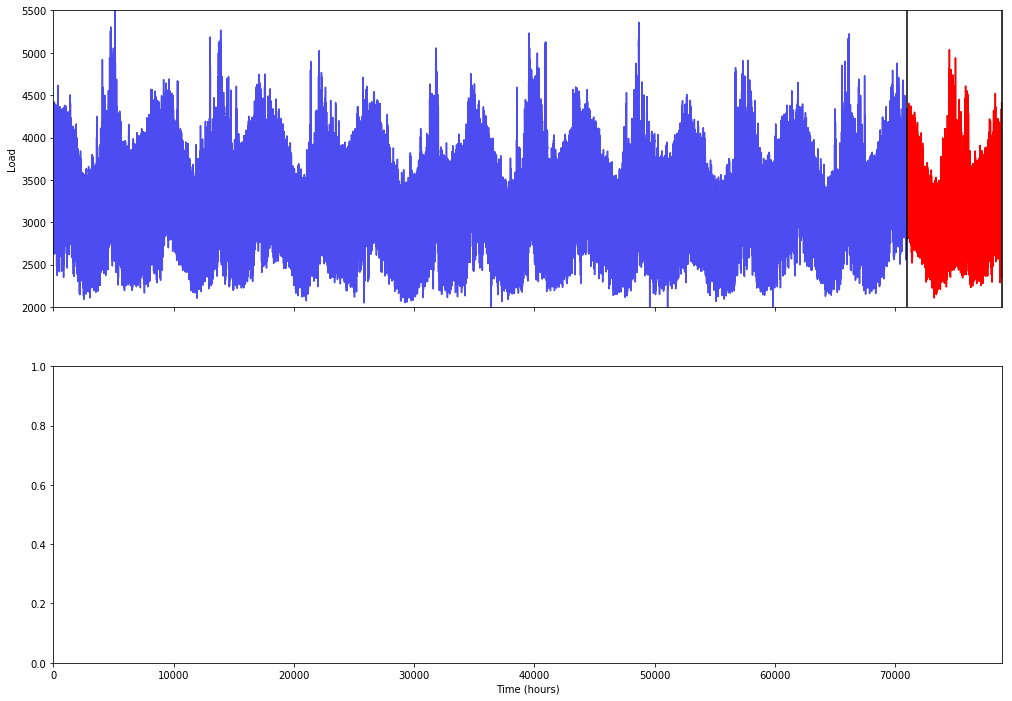

Training fraction: 0.9
Testing fraction: 0.1
Training data points: 70999
Testing data points: 7888


<Figure size 432x288 with 0 Axes>

In [16]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds+1, ncols=1, sharex=True, figsize=(17, 12))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.index[i*test_length:i*test_length+train_length]
    y_train = df.load[i*test_length:i*test_length+train_length]
    x_test = df.index[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df.load[i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.index
    y_all = df.load
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_ylim([2000, 5500])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time (hours)')
plt.show()
plt.tight_layout()

# Print the number of training, validation, and testing time steps
print(
    'Training fraction: {}\nTesting fraction: {}\nTraining data points: {}\nTesting data points: {}'.format(
    round((1-n_folds*test_fraction), 3), 
    round(test_fraction, 3),
    int(len(df)*(1-n_folds*test_fraction)), 
    int(len(df)*test_fraction)
))

# Data preparation

In [18]:
# Loading the dataset and dropping unncecessary columns
df = df[-2000:]
data = df.drop(['time', 'month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# # Let's create shifted categorical feature to include information about the future's holiday 
# # structure. This will make it easier for our model to do predictions on holidays
# shifted = data[categorical].shift(-horizon)
# shifted = shifted.rename(columns={column:column + '_shifted' for column in shifted.columns})
# data = pd.concat([data, shifted], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Forecaster

In [19]:
model = models.WaveNet(filters=filter, num_layers=num_layers)
forecaster = Forecaster(model,lag=lag, horizon=horizon, lr=lr, epochs=epochs)

# Fold generator

In [21]:
fold_generator = cv.FoldGenerator(data=data, 
                                  targets=[0], 
                                  lag=lag, 
                                  horizon=horizon, 
                                  test_fraction=test_fraction, 
                                  n_folds=n_folds)

# Evaluator

In [22]:
evaluator = cv.MetricsEvaluator(metrics = ['pinball_loss'], filename='test.pkl')

# Scaler

In [23]:
scaler = cv.VectorScaler(targets = [0, 1])

# Cross-Validator

In [24]:
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

In [19]:
metrics = validator.evaluate()

Validation fold 0 took 287 s.
Validation fold 1 took 388 s.
Validation fold 2 took 227 s.


In [20]:
# Let's look at the cross-validation results
metrics

,rmse,mape,smape,p1,p5,p25,p50,p75,p95,p99
fold,,,,,,,,,,
0,133.29,2.96,2.93,2.41,6.84,26.26,51.03,77.06,95.30,98.51
1,168.38,3.52,3.51,0.92,4.43,21.18,42.66,68.69,92.93,97.71
2,129.97,3.11,3.13,1.07,7.53,31.15,52.83,72.67,90.18,94.92
avg.,143.88,3.20,3.19,1.47,6.27,26.20,48.84,72.81,92.80,97.04
std.,21.28,0.29,0.30,0.82,1.63,4.99,5.43,4.19,2.56,1.89


Text(0,0.5,'Prediction quantile')

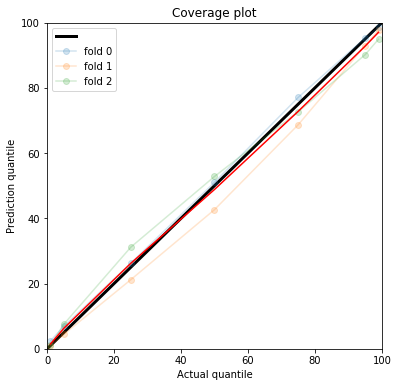

In [21]:
# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for coverage in coverages.values:
    plt.plot(x, coverage, 'o-', alpha=0.2)
plt.plot(x, np.mean(coverages, axis=0), 'r-')
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')

This calibration plots looks awesome. The model was only training on around 75 percent of the available data per fold
and we still achieve good RMSE, MAPE, SMAPE, and coverage of the different percentiles.